---
# 1. 필요 라이브러리 불러오기
---

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- colab 한글 설정

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import konlpy
import gensim
import sklearn
import seaborn as sns
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy import dot
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(sns.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


In [ ]:
import warnings
warnings.filterwarnings('ignore')

---
# 2. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
---

In [ ]:
with open('/content/drive/MyDrive/aiffel/Going_Deeper/GD6/data/synopsis/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [ ]:
okt = Okt()
tokenized = []
with open('/content/drive/MyDrive/aiffel/Going_Deeper/GD6/data/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

---
# 3. 추출된 결과로 embedding model 만들기
---

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# 제일 높은 순 100개 / 주위 5개 고려/ 최소 3번 등장 / sg = 0은 CBOW, 1은 Skip-gram
model.wv.most_similar(positive=['영화'])


[('작품', 0.902541995048523),
 ('다큐멘터리', 0.8621088266372681),
 ('드라마', 0.833670973777771),
 ('영화로', 0.8311475515365601),
 ('주제', 0.809263288974762),
 ('코미디', 0.8056872487068176),
 ('형식', 0.8050216436386108),
 ('감동', 0.8037468194961548),
 ('소재', 0.7971990704536438),
 ('편의', 0.7921154499053955)]

In [ ]:
model.wv.most_similar(positive=['사랑','공포'])

[('혼란', 0.8558675050735474),
 ('내면', 0.8518610596656799),
 ('고독', 0.8434309959411621),
 ('불안', 0.8426802158355713),
 ('비극', 0.8419432640075684),
 ('결말', 0.8414685726165771),
 ('믿음', 0.8392223119735718),
 ('파국', 0.8357212543487549),
 ('치유', 0.8291808366775513),
 ('두려움', 0.8282053470611572)]

이질적으로 생각되는 단어 2개를 넣어서 보았다.  
2단어와 비슷한 느낌을 받을 수 있는 단어들이 나온 것 같다.

In [ ]:
model.wv.most_similar(positive=['공포'])

[('현상', 0.8997913002967834),
 ('혼란', 0.8777710199356079),
 ('미스터리', 0.8602166175842285),
 ('불안', 0.8413325548171997),
 ('실체', 0.830997884273529),
 ('혼돈', 0.829603910446167),
 ('소용돌이', 0.8243396282196045),
 ('진실', 0.8210809826850891),
 ('결말', 0.8160545825958252),
 ('그림자', 0.8154474496841431)]

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'


# 문장단위로 읽은 뒤 명사로 쪼개는 함수
def read_token(file_name):
    okt = Okt()
    result = []
    with open('/content/drive/MyDrive/aiffel/Going_Deeper/GD6/data/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
# 예술영화, 상업영화 읽기
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [ ]:
# Tfidf 객체 생성
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen]) # 예술영화와 상업영화 fit과 transform을 동시에 수행

print(X.shape)

(2, 41082)


In [ ]:
m1 = X[0].tocoo() # 예술영화를 TF-IDF로 표현한 spart matrix를 가져옵니다.
m2 = X[1].tocoo() # 상업영화를 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True) # 예술영화를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key=lambda x: x[1], reverse=True) # 상업영화를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

# 예술영화를 대표하는 단어들
for i in range(30):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')
print('\n','='*150)
# 일반영화를 대표하는 단어들
for i in range(30):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 

In [ ]:
# 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])
    
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print('예술영화 유니크 단어 :',target_art)
print('='*150)
print('상업영화 유니크 단어 :',target_gen)

예술영화 유니크 단어 : ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
상업영화 유니크 단어 : ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


---
# 4. target, attribute 단어 셋 만들기
---

In [ ]:
# 장르별 리스트 설정
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
# 장르별 명사 추출
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
# TF-IDF 벡터화

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [ ]:
# 각 장르를 대표하는 단어들 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print('\n')

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 

가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 

공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 

공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 

기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 

다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 

드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 

멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 

뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 

미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 

범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 

사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 

서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 

성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 

스릴러

---
# 5. embedding model과 단어 셋으로 WEAT score 구해보기
---

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
# 코사인 유사도 함수
def cos_sim(i, j):
    return dot(i, j.T) / (norm(i)*norm(j))

# 코사인 유사도 비교 함수
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

# WEAT score 구현
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [ ]:
# numpy array 형태로 변환
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

- 결과값이 1,-1을 초과하는 점수를 가진 항목들을 뽑아보겠다.

In [ ]:
# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.0 or matrix[i][j] < -1.0:
            print(genre_name[i], genre_name[j],matrix[i][j])
            print('\n')

SF 멜로로맨스 -1.3144456


공포(호러) 다큐멘터리 1.1774539


기타 멜로로맨스 -1.1837618


다큐멘터리 멜로로맨스 -1.4829949


다큐멘터리 미스터리 -1.3108155


다큐멘터리 사극 -1.0001193


다큐멘터리 성인물(에로) -1.2559059


다큐멘터리 스릴러 -1.2010201


다큐멘터리 어드벤처 -1.0107467


멜로로맨스 뮤지컬 1.1026876


멜로로맨스 범죄 1.1729002


멜로로맨스 서부극(웨스턴) 1.1239263


멜로로맨스 애니메이션 1.1745058


멜로로맨스 액션 1.053731


멜로로맨스 전쟁 1.4194626


미스터리 전쟁 1.1493464


성인물(에로) 전쟁 1.0677178




결과값을 해석해보자면  
가장 많이 등장하는 항목인 멜로로맨스 예술영화에 가깝고,  
다큐멘터리는 일반영화에 가깝다. 


- -0.2 < x < 0.2의 편향성이 적을 것이라 생각되는 수치를 기준으로 뽑아보겠다.

In [ ]:
# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] < 0.2 and matrix[i][j] > -0.2:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 판타지 -0.10375563
가족 공연 0.1359499
가족 공포(호러) -0.12821186
가족 드라마 0.10027599
가족 범죄 0.17435007
가족 사극 0.014428128
가족 서부극(웨스턴) 0.16660081
가족 스릴러 -0.15154988
가족 액션 0.094691224
가족 어드벤처 0.017613387
가족 코미디 0.106988974
공연 드라마 -0.028641023
공연 범죄 0.020219121
공연 사극 -0.15110117
공연 서부극(웨스턴) 0.0138959
공연 액션 -0.0700277
공연 어드벤처 -0.15015244
공연 코미디 -0.029596934
공연 판타지 0.15740006
공포(호러) 사극 0.1965744
공포(호러) 스릴러 -0.037371617
기타 뮤지컬 0.01944395
기타 애니메이션 -0.022249917
기타 전쟁 -0.17443964
드라마 범죄 0.051123057
드라마 사극 -0.10471997
드라마 서부극(웨스턴) 0.045065194
드라마 액션 -0.029218303
드라마 어드벤처 -0.10303446
드라마 코미디 0.00096287596
드라마 판타지 0.17244375
뮤지컬 애니메이션 -0.040237788
뮤지컬 전쟁 -0.18046518
미스터리 성인물(에로) -0.033901084
범죄 서부극(웨스턴) -0.007832881
범죄 액션 -0.11946766
범죄 코미디 -0.054889664
범죄 판타지 0.16754116
사극 액션 0.106788464
사극 어드벤처 0.003922778
사극 코미디 0.114738226
서부극(웨스턴) 액션 -0.10780245
서부극(웨스턴) 코미디 -0.048101187
서부극(웨스턴) 판타지 0.1700442
애니메이션 전쟁 -0.14882086
액션 어드벤처 -0.10523045
액션 코미디 0.03324054
어드벤처 코미디 0.11318842
코미디 판타지 0.182731


---
# 6. 시각화
---

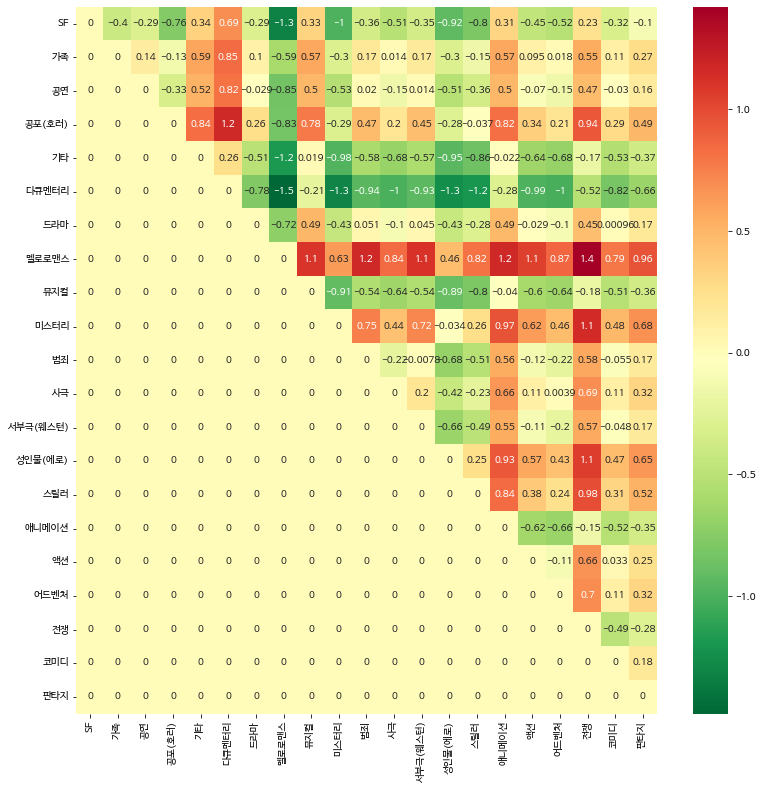

In [ ]:
np.random.seed(0)

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (13,13))
plt.rc('font', family='NanumBarunGothic')

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

---
# 7. embeding model 바꿔보기
---

이전 임베딩은 방식인 CBOW에서 Skip-gram 방식으로 변경을 해보고 
어떤 차이가 있는지 확인해보겠다.

In [ ]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.902541995048523),
 ('다큐멘터리', 0.8621088266372681),
 ('드라마', 0.833670973777771),
 ('영화로', 0.8311475515365601),
 ('주제', 0.809263288974762),
 ('코미디', 0.8056872487068176),
 ('형식', 0.8050216436386108),
 ('감동', 0.8037468194961548),
 ('소재', 0.7971990704536438),
 ('편의', 0.7921154499053955)]

In [ ]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model2 = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=1)  
# 제일 높은 순 100개 / 주위 5개 고려/ 최소 3번 등장 / sg = 0은 CBOW, 1은 Skip-gram
model2.wv.most_similar(positive=['영화'])

[('영화로', 0.7723497152328491),
 ('드라마', 0.7374146580696106),
 ('픽션', 0.7353469133377075),
 ('작품', 0.7321386337280273),
 ('설정', 0.715094804763794),
 ('극영화', 0.7129560708999634),
 ('전작', 0.7126153707504272),
 ('형식', 0.7116385698318481),
 ('코미디', 0.7115159034729004),
 ('공포영화', 0.7113118171691895)]

이전의 값과 비교했을때, '영화로'가 최우선 순위로 올라갔으며,  
'다큐멘터리'가 빠졌다.

In [ ]:
# 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출
n = 15
w1_2, w2_2 = [], []
for i in range(100):
    w1_2.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_2.append(vectorizer.get_feature_names()[w2[i][0]])
    
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art2, target_gen2 = [], []
for i in range(100):
    if (w1_2[i] not in w2_2) and (w1_2[i] in model2.wv): target_art2.append(w1_2[i])
    if len(target_art2) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_2[i] not in w1_2) and (w2_2[i] in model2.wv): target_gen2.append(w2_2[i])
    if len(target_gen2) == n: break

In [ ]:
print('CBOW 예술영화 유니크 단어 :',target_art)
print('-'*150)
print('Skip-gram 예술영화 유니크 단어 :',target_art2)
print('='*150)
print('='*150)
print('CBOW 상업영화 유니크 단어 :',target_gen)
print('-'*150)
print('Skip-gram 상업영화 유니크 단어 :',target_gen2)

CBOW 예술영화 유니크 단어 : ['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
------------------------------------------------------------------------------------------------------------------------------------------------------
Skip-gram 예술영화 유니크 단어 : ['결말', '존엄성', '억지', '의치', '젠스', '감언이설', '마술피리', '진국', '철곤', '녹색혁명', '그래퍼']
CBOW 상업영화 유니크 단어 : ['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']
------------------------------------------------------------------------------------------------------------------------------------------------------
Skip-gram 상업영화 유니크 단어 : ['새신랑', '아테나', '어쩌다가', '가족', '제스처', '에세이', '삐라', '다르덴', '보장', '유람선', '계약서']


유니크의 단어도 대부분 변경되었다.

---
### 7-1 WEAT Score 구해보기
---

In [ ]:
matrix2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
# numpy array 형태로 변환
A2 = np.array([model2.wv[word] for word in target_art2])
B2 = np.array([model2.wv[word] for word in target_gen2])

# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X2 = np.array([model2.wv[word] for word in attributes[i]])
        Y2 = np.array([model2.wv[word] for word in attributes[j]])
        matrix2[i][j] = weat_score(X2, Y2, A2, B2)

In [ ]:
# 매트릭스 채우기
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix2[i][j] > 1.0 or matrix2[i][j] < -1.0:
            print(genre_name[i], genre_name[j],matrix2[i][j])
            print('\n')

SF 가족 1.3021121


SF 기타 1.3741996


SF 다큐멘터리 1.4299049


SF 드라마 1.2174082


SF 뮤지컬 1.1224366


SF 애니메이션 1.3784437


가족 미스터리 -1.1655524


가족 사극 -1.0820259


가족 스릴러 -1.0468334


가족 전쟁 -1.0052557


공연 다큐멘터리 1.0296353


기타 멜로로맨스 -1.0329577


기타 미스터리 -1.2360854


기타 사극 -1.1559066


기타 스릴러 -1.151203


기타 전쟁 -1.0608604


다큐멘터리 멜로로맨스 -1.111836


다큐멘터리 미스터리 -1.2919012


다큐멘터리 사극 -1.2158238


다큐멘터리 스릴러 -1.242157


다큐멘터리 전쟁 -1.1052591


드라마 미스터리 -1.0383055


멜로로맨스 애니메이션 1.0285356


미스터리 애니메이션 1.2355545


사극 애니메이션 1.1532488


스릴러 애니메이션 1.1546632


애니메이션 전쟁 -1.0524845




이전에는 멜로로맨스가 예술영화에 포함되었으나, 같은 수치값을 기준으로 비교했을 때,  
멜로로맨스는 완전하게 예술영화와 가깝다고 하기 어려운 값으로 보인다.  
반대로 SF가 예술영화에 가까운 것으로 나타난다.
  
일반영화에 가까운 장르는 애니메이션, 다큐멘터리, 가족, 기타가 있다.

---
### 7-2 시각화
---

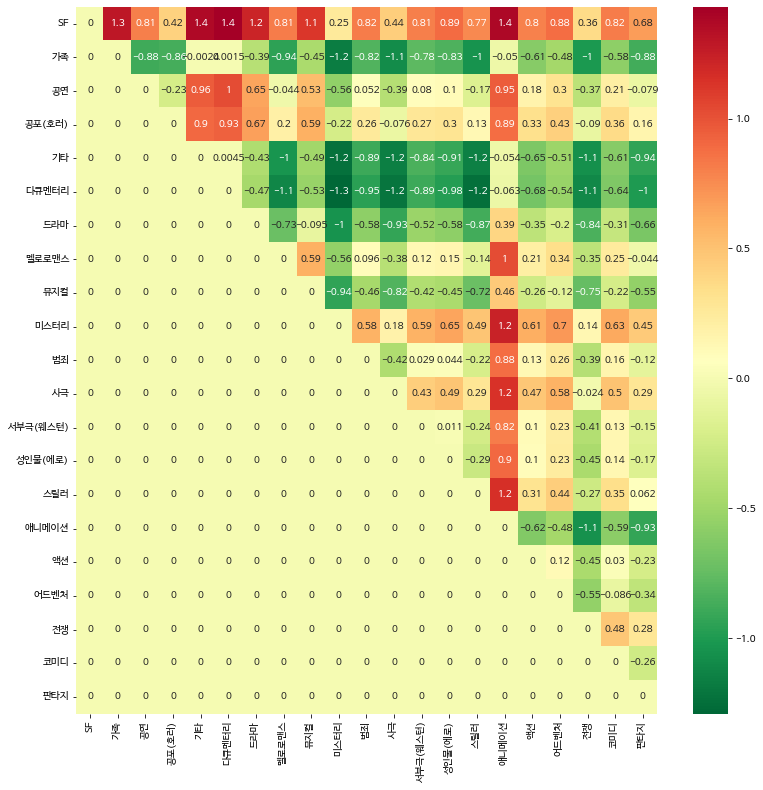

In [ ]:
np.random.seed(0)

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (13,13))
plt.rc('font', family='NanumBarunGothic')

ax = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

---
# 8. 시각화 비교
---

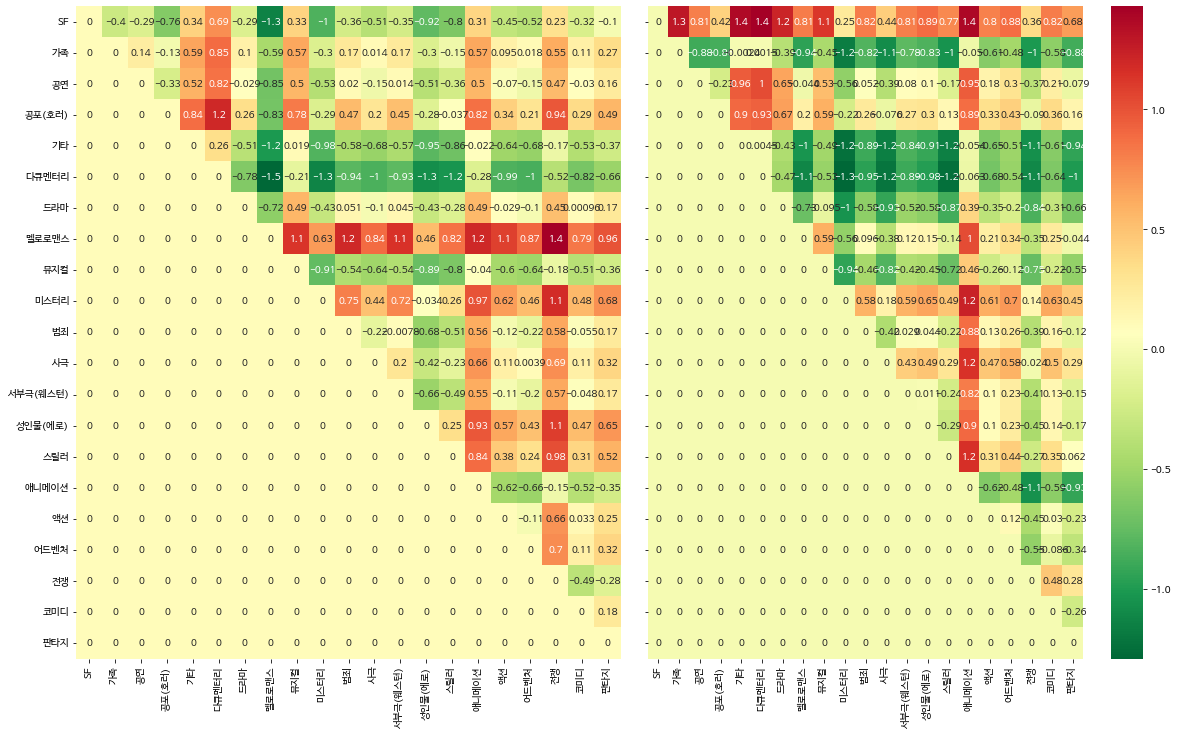

In [ ]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12),sharey = True)
 
g1 = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', cbar = False , ax = ax1)
g1.set_ylabel('')
g2 = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r', cbar = True , ax = ax2)
g2.set_ylabel('')
plt.subplots_adjust(wspace=0.05)

---
# 9. 회고
---

- CBOW와 Skip-gram 에 따른, 편향성에 대한 차이를 비교해보았다.
- 확연히 임베딩 방식에 따라 의미의 편향이 달라지는 것을 눈으로 확인할 수 있는 기회였다. 
- 위 그래프의 우측 skip-gram 방식이 편향의 정도가 더 심해지는 것을 볼 수 있다.
- 해당 이유에 대해 고민해보자면, skip-gram의 경우 중심 단어를 통해 주변 단어를 예측하기 때문에
- output layer에서 softmax 함수를 통해 결과값이 나온다. 
- 그로인해 비슷한 의미를 가지고 있는 단어끼리 모여 있는 장점이 있으나, 그로인해 편향이 더 심하게 나타날 수 있다고 생각이 든다.